In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import matplotlib.colors as colors
from os import listdir, mkdir
from os.path import isfile, sep
from glob import glob
from scipy.interpolate import interp1d

import seaborn as sns
sns.set_style('ticks')

from sys import path

# Import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import *
from velocityDistributionPlots import *

%matplotlib inline

### Load raw data
#### Choose files to analyse

In [741]:
dataDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/'
flyID = 'WTBxpBDPGal4m07'
expDir = dataDir + 'rawData/' + flyID + '/'
FODataFiles = listdir(expDir)

try:
    
    mkdir(dataDir + 'analysis/')
except OSError:
    print('Analysis directory already exists.')

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)
FODataFiles

Analysis directory already exists.


['WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114183356.txt',
 'WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114184401.txt',
 'WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114190835.txt',
 'WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_5-6d_out_151114185635.txt']

In [795]:
# choose experiment
trial = 4

FODataFile = FODataFiles[trial-1]
print(FODataFile)

dataFileParts = FODataFile.split('_')
titleString = 'fly ' + flyID + ' in ' + dataFileParts[2] + ' of ' + dataFileParts[3] + ', trial' + str(trial)
print(titleString)

if ('Invisible' in FODataFile or 'invisible' in FODataFile):
    objecttype = 'invisible'
else:
    objecttype = 'visible'

WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_5-6d_out_151114185635.txt
fly WTBxpBDPGal4m07 in singleObjectForest of 1cm4cmInvisibleCone, trial4


#### Load or read in logfile data

##### Parse header

In [796]:
with open(expDir + FODataFile) as FOf:
    lines = FOf.read().splitlines()

#find beginning of data
firstDataLine = 0
while(lines[firstDataLine][0] == '#'):
    firstDataLine += 1
header = lines[firstDataLine-1][:].split()[1:]

# Get calibration parameter from header
currHeaderLine = 0
while(lines[currHeaderLine][0] == '#'):
    if((lines[currHeaderLine].split(' ')[1] == 'Treadmill') & (lines[currHeaderLine].split(' ')[2] == 'ball')):
        ballRadius_mm = lines[currHeaderLine].split(' ')[-2]
        xRotCalib_ticksPerSemicirc = lines[currHeaderLine+1].split(' ')[-2]
        yRotCalib_ticksPerSemicirc = lines[currHeaderLine+2].split(' ')[-2]
        zRotCalib_ticksPerSemicirc = lines[currHeaderLine+3].split(' ')[-2]
        
        break
    currHeaderLine += 1
print('ball radius = ' + ballRadius_mm)

ball radius = 4.525


##### Parse data

In [797]:
# move text data into a np array
numFrames = len(lines[firstDataLine:-1])

loadNPYFile = False

#check if data has been loaded before
if (loadNPYFile and isfile(expDir + FODataFile[:-3] + 'npy')):
    FOData = np.load(expDir + FODataFile[:-3] + 'npy')
    print('loaded data from file')
else:
    frameRange = range(0,numFrames)

    FOData = np.zeros((numFrames,12))
    tmp = np.asarray(lines[firstDataLine:len(lines)+1])

    for line in frameRange:
        FOData[line,:] = np.asarray(tmp[line].split(',')).astype('float')

#### Read in object coordinates

In [798]:
currHeaderLine = 0
while(lines[currHeaderLine][0] == '#'):
    
    if(lines[currHeaderLine].split(' ')[1] == 'Scene'):
        coordFile = lines[currHeaderLine].split(' ')[-1].split('/')[-1]
        coordFile = coordFile[0:-3] + 'coords'
        break
    currHeaderLine += 1

In [799]:
with open(dataDir + 'rawData/' + coordFile) as Coof:
    lines = Coof.read().splitlines()
    
visibleObjectCoords = []
invisibleObjectCoords = []

for line in range(len(lines)):
    currObject = lines[line].split(' ')
    
    if len(currObject) < 3:
        continue
    
    if (currObject[0][0] == '_'):
        #print("invisible")
        invisibleObjectCoords.append(np.asarray((float(currObject[2]),float(currObject[3]))))   
    elif(currObject[0] == 'Origin'):
        origin = [float(currObject[2]),float(currObject[3])]
    else:
        #print("visible")
        visibleObjectCoords.append(np.asarray((float(currObject[2]),float(currObject[3]))))
    
    #print(currObject[0])
    
invisibleObjectCoords = np.asarray(invisibleObjectCoords)
visibleObjectCoords = np.asarray(visibleObjectCoords)

#### Compute movement velocities

In [800]:
# Convert heading angle (FlyOver) to rad
angle = np.zeros(len(FOData[:,0]))
angle[:] = np.pi/180*FOData[:,5]
#angle[np.pi/180*FOData[:,5]>np.pi] = angle[np.pi/180*FOData[:,5] > np.pi] - np.pi
#angle[np.pi/180*FOData[:,5]<np.pi] = angle[np.pi/180*FOData[:,5] < np.pi] + np.pi

# Compute translational and rotational velocity
logTime = FOData[:,0]
time = FOData[:,0]#np.linspace(0,logTime[-1],numFrames)

vTrans = np.zeros(numFrames)
vTrans[0:-1] = np.sqrt(np.square(np.diff(FOData[:,1])),np.square(np.diff(FOData[:,2]))) / np.diff(time)
vTrans[np.where(np.isnan(vTrans))[0]] = 0

vRot = np.zeros(numFrames)
vRot[0:-1] = np.diff(angle)
vRot[vRot > np.pi] = vRot[vRot > np.pi] - 2*np.pi
vRot[vRot <= -np.pi] = vRot[vRot <= -np.pi] + 2*np.pi
vRot[0:-1] = vRot[0:-1] / np.diff(time)
vRot[np.where(np.isnan(vRot))[0]] = 0

# Filter translational and rotational velocities
N = 60
vTransFilt= np.convolve(vTrans, np.ones((N,))/N, mode='same')
vRotFilt= np.convolve(vRot, np.ones((N,))/N, mode='same')

### Generate basic analysis plots
#### Time step plot

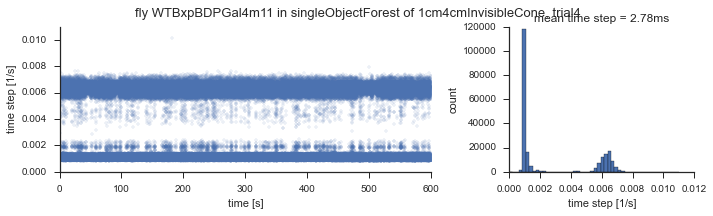

In [704]:
tstpfig = plt.figure(figsize = (10,3))
gs = gridspec.GridSpec(1,2,width_ratios=np.hstack((2,1)))
tstpfig.suptitle( titleString, fontsize = 13)

histRange = (0,0.011)

ax = tstpfig.add_subplot(gs[0])
ax.plot(FOData[0:-2,0],(FOData[1:-1,0]-FOData[0:-2,0]).astype('float'),'.', alpha = 0.1)
ax.set_ylim(histRange)
ax.set_xlim((0,time[-1]))
ax.set_xlabel('time [s]')
ax.set_ylabel('time step [1/s]')
myAxisTheme(ax)

ax = tstpfig.add_subplot(gs[1])
ax.hist(FOData[1:-1,0]-FOData[0:-2,0],50,histRange)
ax.set_xlabel('time step [1/s]')
ax.set_ylabel('count')
ax.set_title('mean time step = ' + str(round(np.mean((FOData[1:-1,0]-FOData[0:-2,0])*1000.0),2)) + 'ms' )
myAxisTheme(ax)

tstpfig.tight_layout()

In [36]:
try:
    mkdir(dataDir + 'analysis/timeStepPlot/')
except OSError:
    print('Plot directory already exists.')
    
tstpfig.savefig(dataDir + 'analysis/timeStepPlot/' + FODataFile[0:-4] + '_timeStepPlot.pdf', format = 'pdf')

Plot directory already exists.


####Trace plots

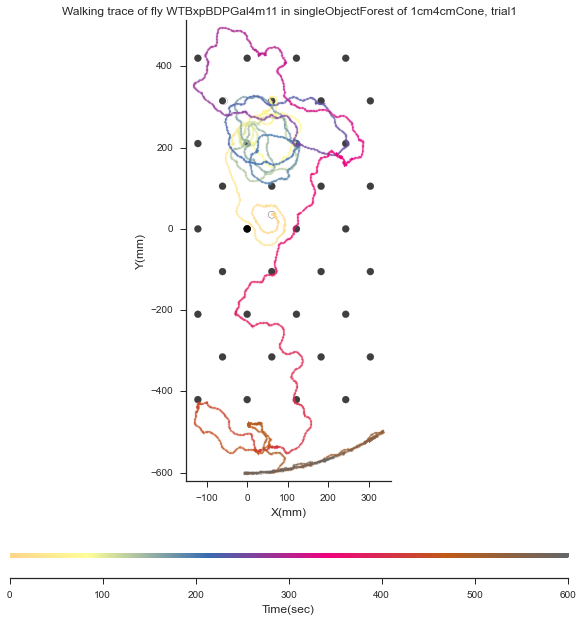

In [14]:
# Plot trace and mark object locations
tStart = 0
tEnd = len(FOData[:,1])
tStep = 72
frameRange = range(tStart,tEnd,tStep)
colMap = 'Accent' #'nipy_spectral'
arrowLength = 5

trajfig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2,1,height_ratios=np.hstack((10,1)))

axTraj = trajfig.add_subplot(gs[0]) #trace plot
axTime = trajfig.add_subplot(gs[1]) #time line

plotPosInRange(axTraj,axTime,frameRange,FOData[:,0],FOData[:,1],FOData[:,2],np.pi/180*FOData[:,5],colMap,arrowLength,0.5,5)
axTraj.scatter(visibleObjectCoords[:,0],visibleObjectCoords[:,1], 50, alpha=0.75,facecolor='black',edgecolors='none')
axTraj.scatter(invisibleObjectCoords[:,0],invisibleObjectCoords[:,1], 50, alpha=0.5, facecolors='none', edgecolors='black') 
axTraj.set_xlabel(header[1],fontsize=12)
axTraj.set_ylabel(header[2],fontsize=12)  
axTraj.set_title('Walking trace of ' + titleString)
axTraj.set_xlim([min(FOData[:,1]) - 20, max(FOData[:,1]) + 20])
axTraj.set_ylim([min(FOData[:,2]) - 20, max(FOData[:,2]) + 20])
myAxisTheme(axTraj)

axTime.set_xlabel(header[0],fontsize=12)  
plt.xlim((0,FOData[-1,0]))
timeAxisTheme(axTime)

In [494]:
try:
    mkdir(dataDir + 'analysis/tracePlot/')
except OSError:
    print('Plot directory already exists.')
    
trajfig.savefig(dataDir + 'analysis/tracePlot/' + FODataFile[0:-4] + '_traceObjectPlot.pdf', format = 'pdf')

Plot directory already exists.


#### Velocity distributions

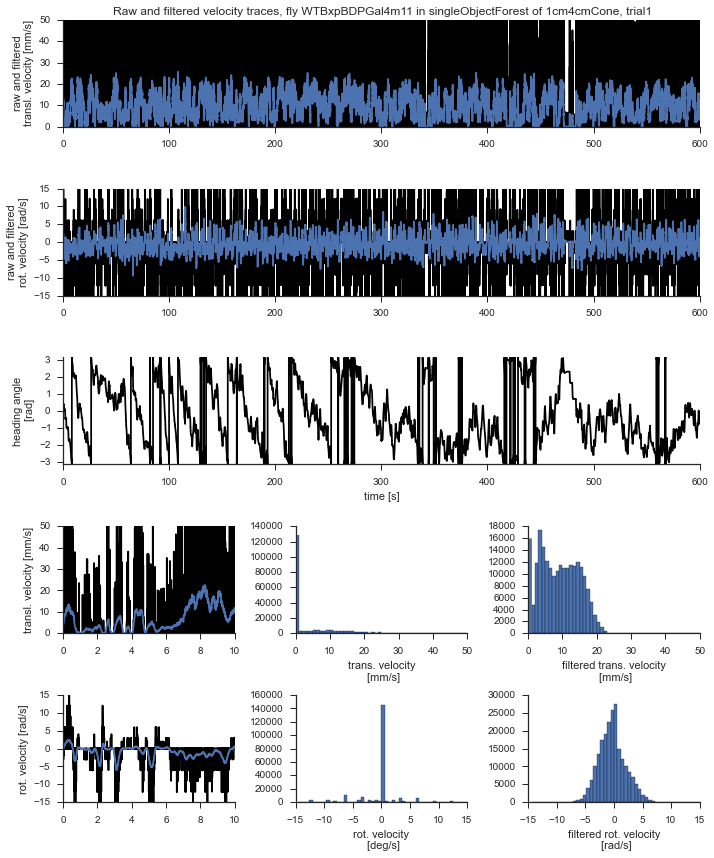

In [15]:
rotLim = (-15, 15)
transLim = (0, 50)
angleLim = (-np.pi, np.pi)
summaryVeloFig = velocitySummaryPlot(time, vTrans, vTransFilt, vRot, vRotFilt, angle, rotLim, transLim, angleLim,
                                     'Raw and filtered velocity traces, ' + titleString)

In [393]:
try:
    mkdir(dataDir + 'analysis/velocityTraces/')
except OSError:
    print('Plot directory already exists.')
    
summaryVeloFig.savefig(dataDir + 'analysis/velocityTraces/' + FODataFile[0:-4] + '_veloTraces.pdf', format = 'pdf')

Plot directory already exists.


### Collapes traces to single object cell

In [801]:
path.insert(0, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from periodicWorldAnalysis import *

# Extract hex grid geometry
#objDistances = np.asarray([visibleObjectCoords[:,0]-visibleObjectCoords[:,i] for i in range(visibleObjectCoords[0,:].size)])
#aTrgle = np.floor(2*np.min(abs(objDistances[np.nonzero(objDistances[:,0]),0])))
#hTrgle = np.min(abs(objDistances[np.nonzero(objDistances[:,1]),1]))

# Collapse to 'mini-arena' while preserving the global heading
arenaRad = 60
if objecttype == 'visible':
    objectCoords = np.copy(visibleObjectCoords[0:-3,0:2])
else:
    objectCoords = np.copy(invisibleObjectCoords[:,0:2])
    
xPosMA, yPosMA = collapseToMiniArena(FOData[:,1], FOData[:,2], arenaRad, objectCoords)

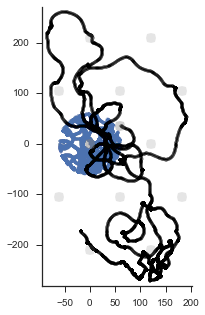

In [802]:
testfig = plt.figure(figsize=(5,5))

projPlot = testfig.add_subplot(111)
projPlot.plot(xPosMA,yPosMA,'.',alpha = 0.02)
projPlot.plot(FOData[:,1],FOData[:,2],'k.',alpha = 0.01)
projPlot.plot(visibleObjectCoords[0:-3,0],visibleObjectCoords[0:-3,1],marker='o',markersize=10,linestyle='none',
            alpha=0.5,color='black') 
projPlot.plot(invisibleObjectCoords[0:-3,0],invisibleObjectCoords[0:-3,1],marker='o',markersize=10,linestyle='none',
            alpha=0.2,color='grey') 
projPlot.set_xlim([min(min(FOData[:,1])-10,-80), max(max(FOData[:,1])+10, 65)])
projPlot.set_ylim([min(min(FOData[:,2])-10, -80), max(max(FOData[:,2])+10, 65)])
projPlot.set_aspect('equal')
myAxisTheme(projPlot)

### Downsample data to 20 Hz

In [803]:
samplingRate = 20
time_ds = np.linspace(time[0],time[-1],round(20*logTime[-1]))

numFrames_ds = len(time_ds)

f_xPos = interp1d(time, FOData[:,1], kind='linear')
f_yPos = interp1d(time, FOData[:,2], kind='linear')

f_xPosMA = interp1d(time, xPosMA, kind='linear')
f_yPosMA = interp1d(time, yPosMA, kind='linear')

f_angle = interp1d(time, angle, kind='linear')

xPos_ds = f_xPos(time_ds)
yPos_ds = f_yPos(time_ds)

xPosMA_ds = f_xPosMA(time_ds)
yPosMA_ds = f_yPosMA(time_ds)

angle_ds = f_angle(time_ds)

In [804]:
# Compute downsampled translational and rotational velocity
vTrans_ds = np.zeros(numFrames_ds)
vRot_ds = np.zeros(numFrames_ds)

vTrans_ds[0:-1] = np.hypot(np.diff(xPos_ds),np.diff(yPos_ds)) / np.diff(time_ds)

vRot_ds[0:-1] = np.diff(angle_ds)
vRot_ds[vRot_ds>np.pi] = vRot_ds[vRot_ds>np.pi]-2*np.pi
vRot_ds[vRot_ds<-np.pi] = vRot_ds[vRot_ds<-np.pi]+2*np.pi
vRot_ds[0:-1] = vRot_ds[0:-1]/ np.diff(time_ds)

vTrans_ds[np.where(np.isnan(vTrans_ds))[0]] = 0
vRot_ds[np.where(np.isnan(vRot_ds))[0]] = 0

# Filter translational and rotational velocities
N = 5
vTransFilt_ds = np.convolve(vTrans_ds, np.ones((N,))/N, mode='same')
vRotFilt_ds = np.convolve(vRot_ds, np.ones((N,))/N, mode='same')

####Plot velocity distributions of downsampled data

Plot directory already exists.


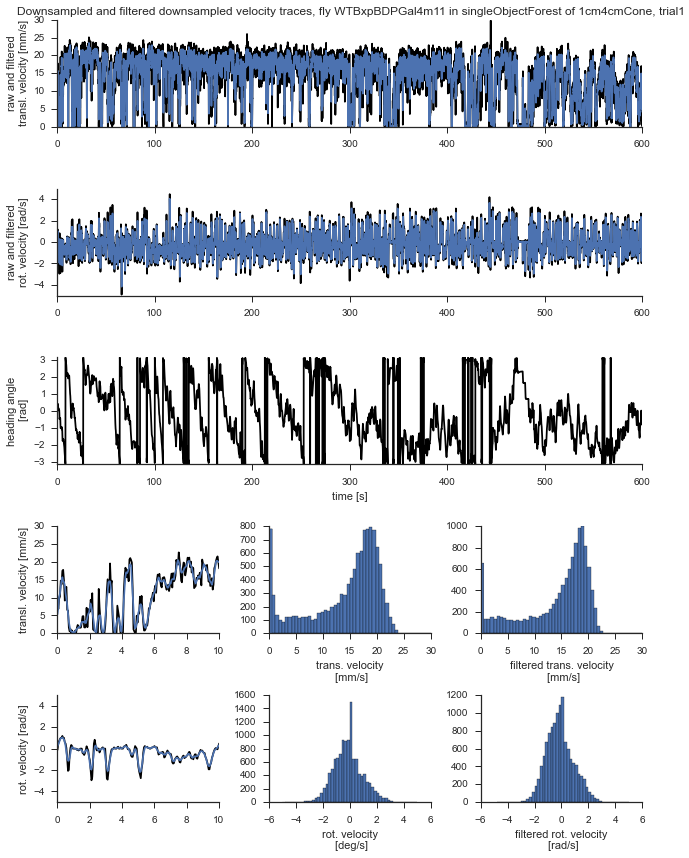

In [19]:
rotLim = (-5, 5)
transLim = (0, 30)
angleLim = (-np.pi, np.pi)
summaryVeloFig_ds = velocitySummaryPlot(time_ds, vTrans_ds, vTransFilt_ds, vRot_ds, vRotFilt_ds, angle_ds,
                                        rotLim, transLim, angleLim, 'Downsampled and filtered downsampled velocity traces, ' + titleString)

try:
    mkdir(dataDir + 'analysis/velocityTraces/')
except OSError:
    print('Plot directory already exists.')
    
#summaryVeloFig_ds.savefig(dataDir + 'analysis/velocityTraces/' + FODataFile[0:-4] + '_veloTraces_ds.pdf', format = 'pdf')

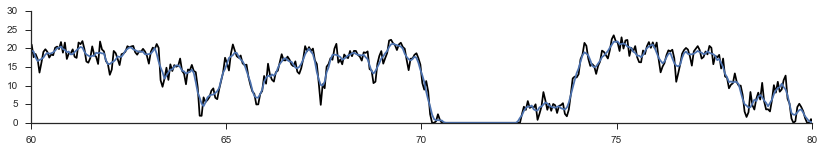

In [805]:
fig = plt.figure(figsize=(14,2))
gs = gridspec.GridSpec(1,1)

plotVeloFiltTrace(time_ds, vTrans_ds, vTransFilt_ds, gs[0], (0,30), (60, 80))

#### Plot collapsed, downsampled trace

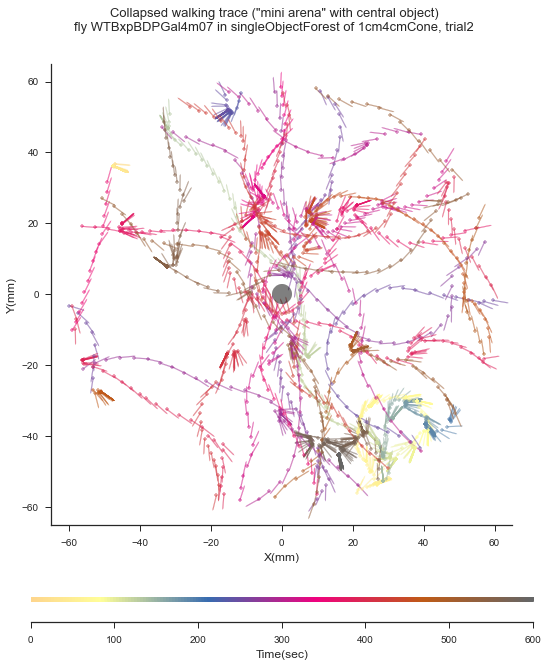

In [753]:
tStart = 0
tEnd = numFrames_ds
tStep = 4
frameRange = range(tStart,tEnd,tStep)
colMap = 'Accent' #'nipy_spectral'
arrowLength = 5

colTrajFig = plt.figure(figsize=(9,10))
gs = gridspec.GridSpec(2,1,height_ratios=np.hstack((10,1)))

colTrajFig.suptitle('Collapsed walking trace ("mini arena" with central object)\n' + titleString, fontsize = 13)

axTraj = colTrajFig.add_subplot(gs[0]) #trace plot
axTime = colTrajFig.add_subplot(gs[1]) #time line
plotPosInRange(axTraj,axTime,frameRange,time_ds,xPosMA_ds,yPosMA_ds,angle_ds,colMap,4,0.5,7)
axTraj.plot(0,0,marker='o',markersize=20,linestyle='none',alpha=0.5,color='black')
axTraj.set_xlabel(header[1],fontsize=12)
axTraj.set_ylabel(header[2],fontsize=12)
axTraj.set_ylim([-arenaRad -5,arenaRad + 5])
axTraj.set_xlim([-arenaRad -5,arenaRad + 5])  
myAxisTheme(axTraj)
axTime.set_xlabel(header[0],fontsize=12)  
plt.xlim((0,time_ds[-1]))
timeAxisTheme(axTime)

#try:
#    mkdir(dataDir + 'analysis/collapsedTracePlot/')
#except OSError:
#    print('Plot directory already exists.')
    
#colTrajFig.savefig(dataDir + 'analysis/collapsedTracePlot/' + FODataFile[0:-4] + '_traceObjectPlot_ds.pdf', format = 'pdf')

In [279]:
xPosMA_ds = FOData[()]['xPosInMiniarena']
yPosMA_ds = FOData[()]['yPosInMiniarena']
time_ds = FOData[()]['time']
angle_ds = FOData[()]['headingAngle']
gamma_ds = FOData[()]['gamma']
vTrans_ds = FOData[()]['transVelo']


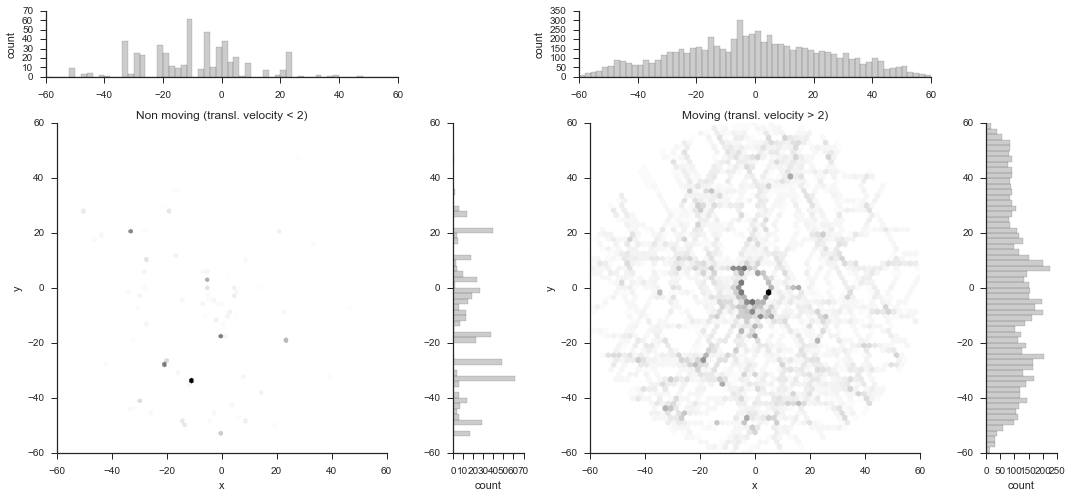

In [30]:
moving = np.asarray(vTrans_ds) > 2

arenaRad = 60
numBins = 60

histRange = (-arenaRad,arenaRad)
gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,5,1], height_ratios=[1,5])
fig = plt.figure(figsize=(15,7))
sns.set_style('ticks')

ax = plt.subplot(gs[0,0])
plt.hist(xPosMA_ds[~moving], bins=numBins, range=histRange, color='grey', alpha=0.4)
ax.set_xlim(histRange)
ax.set_ylabel('count')
myAxisTheme(ax)

ax = plt.subplot(gs[1,1])
plt.hist(yPosMA_ds[~moving], bins=numBins, range=histRange, color='grey', alpha=0.4, orientation='horizontal')
ax.set_ylim(histRange)
ax.set_xlabel('count')
myAxisTheme(ax)
    
ax = fig.add_subplot(gs[1,0])
plt.hexbin(xPosMA_ds[~moving], yPosMA_ds[~moving], gridsize=numBins, cmap='Greys')
plt.xlabel('x'); plt.ylabel('y')
ax.set_xlim(-arenaRad,arenaRad); ax.set_ylim(-arenaRad,arenaRad)
plt.title('Non moving (transl. velocity < 2)')
ax.set_aspect('equal')
myAxisTheme(ax)

ax = plt.subplot(gs[0,2])
plt.hist(xPosMA_ds[moving], bins=numBins, range=histRange, color='grey', alpha=0.4)
ax.set_xlim(histRange)
ax.set_ylabel('count')
myAxisTheme(ax)

ax = plt.subplot(gs[1,3])
plt.hist(yPosMA_ds[moving], bins=numBins, range=histRange, color='grey', alpha=0.4, orientation='horizontal')
ax.set_ylim(histRange)
ax.set_xlabel('count')
myAxisTheme(ax)

ax = fig.add_subplot(gs[1,2])
plt.hexbin(xPosMA_ds[moving], yPosMA_ds[moving], gridsize=numBins, cmap='Greys')
plt.xlabel('x'); plt.ylabel('y')
ax.set_xlim(-arenaRad,arenaRad); ax.set_ylim(-arenaRad,arenaRad)
plt.title('Moving (transl. velocity > 2)')
ax.set_aspect('equal')
myAxisTheme(ax)

fig.tight_layout()

### Compute heading angle relative to closest object (use collapsed coordinates)

In [806]:
def dotProduct_2D(a,b):
    #2D dot product
    return a[0,:]*b[0,:] + a[1,:]*b[1,:]

def vecLength_2D(a):
    return np.sqrt(a[0,:]**2 + a[1,:]**2)

In [807]:
# Vector to object location
objectDirection = np.vstack((-xPosMA_ds,-yPosMA_ds))

objDist = vecLength_2D(objectDirection)

# Fly orientation vector
flyDirection = np.vstack((np.cos(angle_ds),np.sin(angle_ds)))

# Angle to object relative from fly's orientation
dotProd = dotProduct_2D(flyDirection,objectDirection)
lenFlyVec = np.hypot(flyDirection[0,:],flyDirection[1,:])
lenObjVec = np.hypot(objectDirection[0,:],objectDirection[1,:])

gamma = np.arccos( dotProd / (lenFlyVec * lenObjVec) )

gammaFull = np.arctan2(flyDirection[1,:], flyDirection[0,:]) - np.arctan2(objectDirection[1,:], objectDirection[0,:])
gammaFull[gammaFull < 0] += 2 * np.pi
gammaFull[gammaFull > np.pi] -= 2 * np.pi

# Change in heading rel. to object
gammaV = np.hstack((np.diff(gamma)/np.diff(time_ds),0))

In [808]:
sf = 0
ef = len(xPosMA_ds)

turnTH = 3*np.std(abs(vRotFilt_ds))
turnMask = (abs(vRotFilt_ds)>turnTH)

turnindex = vRotFilt_ds/vTransFilt_ds
turnindex[vTransFilt_ds==0] = 0

turnIdxTH = 2*np.std(abs(turnindex))
turnIdxMask = (abs(turnindex)>turnIdxTH)

near = 6
far = 40

selectedRangeDist = np.logical_and(np.logical_and(objDist>near,objDist<far),vTrans_ds>2)
selectedRangeDistTurn = np.logical_and(selectedRangeDist,turnIdxMask)

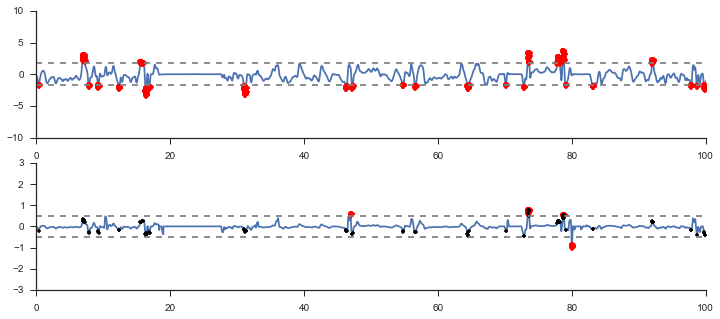

In [809]:
# Try different way of estimating turn based on combination of translational and rotational velocit

turnIdx = plt.figure(figsize=(12,5))
tIax = turnIdx.add_subplot(211)
tIax.plot(time_ds,vRotFilt_ds)
tIax.plot(time_ds[turnMask],vRotFilt_ds[turnMask],'ro')
tIax.axhline(turnTH,color='grey',linestyle='--')
tIax.axhline(-turnTH,color='grey',linestyle='--')
tIax.set_xlim((0,100))
tIax.set_ylim((-10,10))
myAxisTheme(tIax)


tIax = turnIdx.add_subplot(212)
tIax.plot(time_ds,turnindex)
tIax.plot(time_ds[turnIdxMask],turnindex[turnIdxMask],'ro')
tIax.plot(time_ds[turnMask],turnindex[turnMask],'k.')
tIax.axhline(turnIdxTH,color='grey',linestyle='--')
tIax.axhline(-turnIdxTH,color='grey',linestyle='--')
tIax.set_xlim((0,100))
tIax.set_ylim((-3,3))
myAxisTheme(tIax)

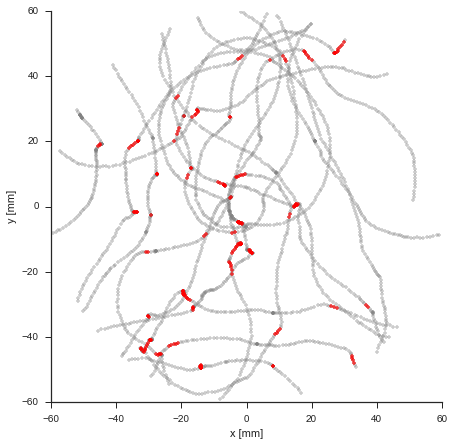

In [38]:
sf=0
ef=3000
combiIdx = np.logical_or(turnIdxMask,turnMask)
turnIdx = plt.figure(figsize=(7,7))
tIax = turnIdx.add_subplot(111)
tIax.plot(xPosMA_ds[sf:ef],yPosMA_ds[sf:ef],'.',color = 'grey',alpha = 0.4)
tIax.plot(xPosMA_ds[combiIdx[sf:ef]],yPosMA_ds[combiIdx[sf:ef]],'.', color='red', alpha = 0.7)
#tIax.plot(xPosMA_ds[turnIdxMask[sf:ef]],yPosMA_ds[turnIdxMask[sf:ef]],'.', color='b', alpha = 0.7)
#tIax.plot(xPosMA_ds[turnMask[sf:ef]],yPosMA_ds[turnMask[sf:ef]],'.', color='k', alpha = 0.7)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
tIax.set_aspect('equal')
myAxisTheme(tIax)

Plot directory already exists.


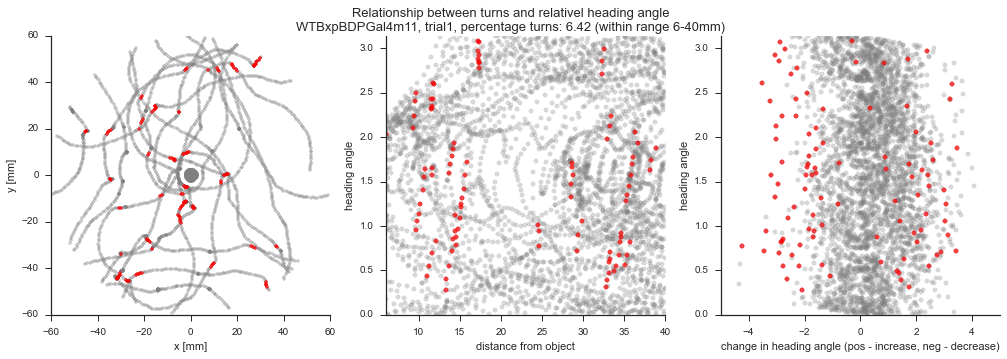

In [39]:
headTurnFig = plt.figure(figsize = (17,5));

headTurnFig.suptitle('Relationship between turns and relativel heading angle\n' + flyID + ', trial' + str(trial) +
                     ', percentage turns: ' + str(round(100.0*sum(turnMask)/len(vRotFilt_ds),2)) + ' (within range ' + str(near) + '-' + str(far) + 'mm)\n', fontsize = 13)

distRange = (near,far); angleRange = (0,np.pi); vHeadRange = (-5,5)

ax0 = headTurnFig.add_subplot(131)
ax0.plot(xPosMA_ds[sf:ef],yPosMA_ds[sf:ef],'.',color = 'grey',alpha = 0.4)
ax0.plot(xPosMA_ds[turnMask[sf:ef]],yPosMA_ds[turnMask[sf:ef]],'.', color='red', alpha = 0.7)
ax0.plot(0,0,marker='o',markersize=15,linestyle='none',alpha=0.5,color='black')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
ax0.set_aspect('equal')
myAxisTheme(ax0)

ax1 = headTurnFig.add_subplot(132)
ax1 = niceScatterPlot(ax1,objDist[selectedRangeDist], gamma[selectedRangeDist],distRange,angleRange,'grey', 0.3)
ax1 = niceScatterPlot(ax1,objDist[selectedRangeDistTurn],gamma[selectedRangeDistTurn],distRange,angleRange,'red', 0.7)
plt.xlabel('distance from object');
plt.ylabel('heading angle');

ax2 = headTurnFig.add_subplot(133);
ax2 = niceScatterPlot(ax2,gammaV[selectedRangeDist],gamma[selectedRangeDist],vHeadRange,angleRange,'grey', 0.3)
ax2 = niceScatterPlot(ax2,gammaV[selectedRangeDistTurn],gamma[selectedRangeDistTurn],vHeadRange,angleRange,'red', 0.7)
plt.xlabel('change in heading angle (pos - increase, neg - decrease)');
plt.ylabel('heading angle');

try:
    mkdir(dataDir + 'analysis/relativeHeading/')
except OSError:
    print('Plot directory already exists.')
    
#headTurnFig.savefig(dataDir + 'analysis/relativeHeading/' + FODataFile[0:-4] + '_headingAndTurns_ds.pdf', format = 'pdf')

Plot directory already exists.


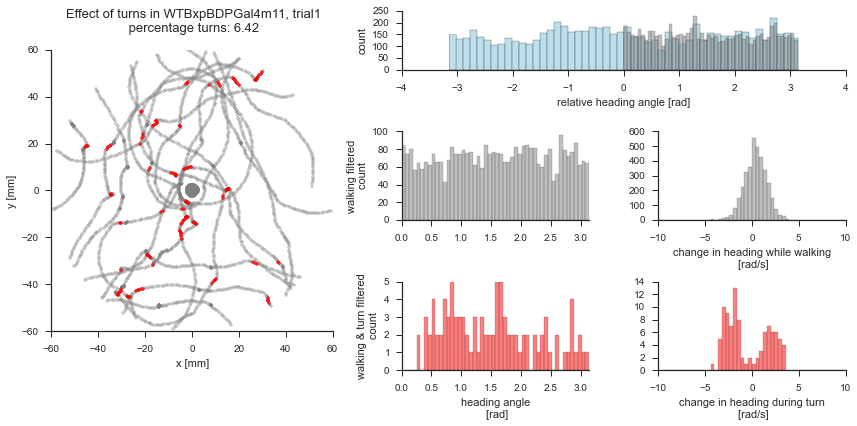

In [40]:
turnEffectFig = plt.figure(figsize = (12,6))
gs = gridspec.GridSpec(3, 3, height_ratios=np.hstack((1, 1.5, 1.5)),width_ratios=np.hstack((1.5, 1, 1)))

ax0 = turnEffectFig.add_subplot(gs[:,0])
ax0.plot(xPosMA_ds[sf:ef],yPosMA_ds[sf:ef],'.',color = 'grey',alpha = 0.4)
ax0.plot(xPosMA_ds[turnMask[sf:ef]],yPosMA_ds[turnMask[sf:ef]],'.', color='red', alpha = 0.7)
ax0.plot(0,0,marker='o',markersize=15,linestyle='none',alpha=0.5,color='black')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
ax0.set_aspect('equal')
myAxisTheme(ax0)
ax0.set_title('Effect of turns in ' + flyID + ', trial' + str(trial) +
                     '\n percentage turns: ' + str(round(100.0*sum(turnMask)/len(vRotFilt_ds),2)) + '\n', fontsize = 13)

ax = turnEffectFig.add_subplot(gs[0,1:3])
plt.hist(gammaFull[~np.isnan(gammaFull)],bins = 50,color = 'lightblue',alpha = 0.8);
plt.hist(gamma[~np.isnan(gamma)],bins = 50,color = 'grey',alpha = 0.5);
plt.xlabel('relative heading angle [rad]')
plt.ylabel('count')
myAxisTheme(ax)

headingHist = plotVeloHistogram_fancy(gamma[selectedRangeDist], gs[1,1], (0, np.pi), 'grey', 0.5)
headingHist.set_ylabel('walking filtered\n count')

headingHistTurn = plotVeloHistogram_fancy(gamma[selectedRangeDistTurn], gs[2,1], (0, np.pi), 'red', 0.5)
headingHistTurn.set_ylabel('walking & turn filtered\n count')
headingHistTurn.set_xlabel('heading angle\n [rad]')

rotVHist = plotVeloHistogram_fancy(gammaV[selectedRangeDist], gs[1,2], (-10, 10), 'grey', 0.5)
rotVHist.set_xlabel('change in heading while walking\n [rad/s]');

rotVHistFilt = plotVeloHistogram_fancy(gammaV[selectedRangeDistTurn], gs[2,2], (-10, 10), 'red', 0.5)
rotVHistFilt.set_xlabel('change in heading during turn\n [rad/s]')

turnEffectFig.tight_layout()

try:
    mkdir(dataDir + 'analysis/effectOfTurn/')
except OSError:
    print('Plot directory already exists.')
    
    
#turnEffectFig.savefig(dataDir + 'analysis/effectOfTurn/' + FODataFile[0:-4] + '_turnHeadingChange.pdf', format = 'pdf')

### "Directional modulation of runs"    -   Gomez-Marin and Louis, 2014

Plot directory already exists.


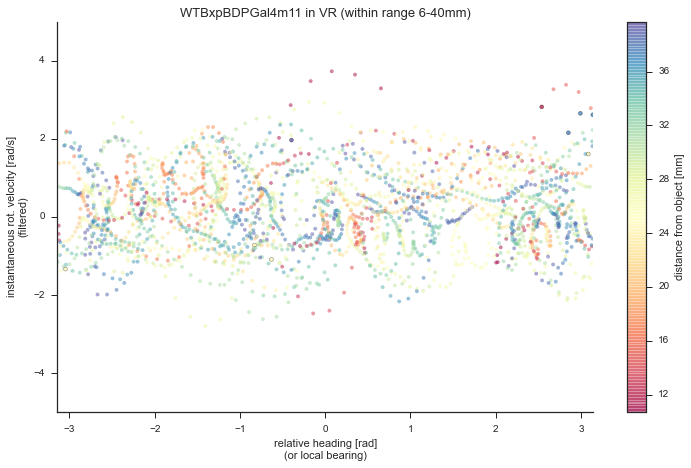

In [715]:
turnModfig = plt.figure(figsize = (12,7))
turnMod = turnModfig.add_subplot(1,1,1)
turnModsc = plt.scatter(gammaFull[selectedRangeDist],vRotFilt_ds[selectedRangeDist],
                        marker='o', s=15, linewidths=0,
                        c=objDist[selectedRangeDist], cmap=plt.cm.Spectral, alpha = 0.5)
turnModsc = plt.scatter(gammaFull[selectedRangeDistTurn],vRotFilt_ds[selectedRangeDistTurn],
                        marker='o', s=15, linewidths=0.5,
                        c=objDist[selectedRangeDistTurn], cmap=plt.cm.Spectral, alpha = 0.5)
turnMod.set_xlim(-np.pi,np.pi)
turnMod.set_ylim(-5,5)
turnMod.set_xlabel('relative heading [rad]\n(or local bearing)')
turnMod.set_ylabel('instantaneous rot. velocity [rad/s]\n(filtered)');

turnModcb = plt.colorbar(turnModsc)
turnModcb.set_label('distance from object [mm]')
myAxisTheme(turnMod)

turnMod.set_title(flyID + ' in VR (within range ' + str(near) + '-' + str(far) + 'mm)',  fontsize = 13)

try:
    mkdir(dataDir + 'analysis/headingVsRotation/')
except OSError:
    print('Plot directory already exists.')
    
#turnModfig.savefig(dataDir + 'analysis/headingVsRotation/' + FODataFile[0:-4] + '_headingVsRotation.pdf', format = 'pdf')

### Modulation of trajectory curvature

In [810]:
from scipy.ndimage.filters import gaussian_filter

# compute first and second derivatives of x and y w.r.t. to t
dxdt = np.zeros(len(xPos_ds))
dydt = np.zeros(len(xPos_ds))

sigma = 3
x_filt = gaussian_filter(xPos_ds, sigma, mode='reflect')
y_filt = gaussian_filter(yPos_ds, sigma, mode='reflect')

dxdt[1:] = np.diff(x_filt)/np.diff(time_ds)
dydt[1:] = np.diff(y_filt)/np.diff(time_ds)

ddxdt = np.zeros(len(xPos_ds))
ddydt = np.zeros(len(xPos_ds))

sigma = 3
dxdt_filt = gaussian_filter(dxdt, sigma, mode='reflect')
dydt_filt = gaussian_filter(dydt, sigma, mode='reflect')

ddxdt[1:] = np.diff(dxdt_filt)/np.diff(time_ds)
ddydt[1:] = np.diff(dydt_filt)/np.diff(time_ds)

curv = (dxdt*ddydt - dydt*ddxdt) / (dxdt*dxdt + dydt*dydt)**(3.0/2.0)

curvTH = 0.3
curvToPlot = np.copy(curv)
curvToPlot[curv > curvTH] = curvTH
curvToPlot[curv < -curvTH] = -curvTH

(-60, 60)

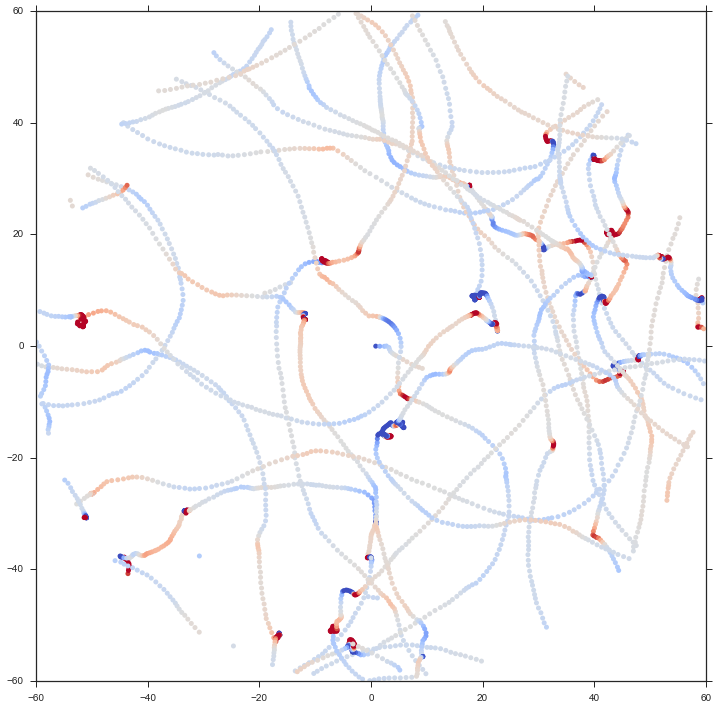

In [811]:
sf=0
ef=5000
fig=plt.figure(figsize=(12,12))
plt.scatter(xPosMA_ds[sf:ef],yPosMA_ds[sf:ef],s=25,c=curvToPlot[sf:ef],cmap='coolwarm',marker='o',edgecolors='none')
plt.xlim(-60,60)
plt.ylim(-60,60)

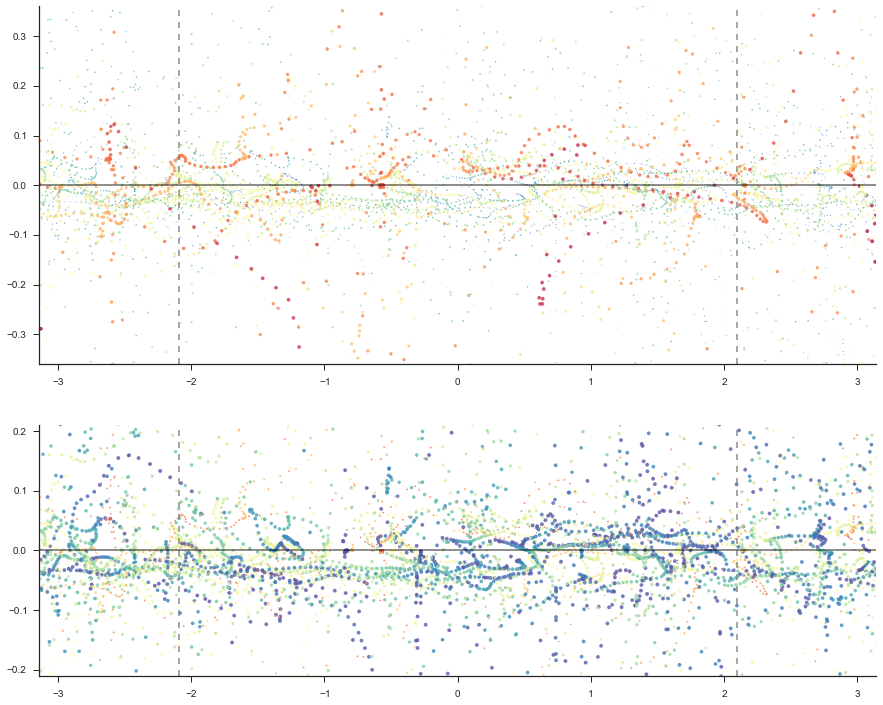

In [812]:
curvHeadingScatter=plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(2,1,height_ratios=[2,1.4])

ax0=curvHeadingScatter.add_subplot(gs[0])
plt.scatter(gammaFull,curv, c=objDist, s=60-objDist,marker='.',alpha=0.8,edgecolors='none',cmap='Spectral')
plt.xlim(-np.pi,np.pi)
plt.ylim(-curvTH*1.2,curvTH*1.2)

ax1=curvHeadingScatter.add_subplot(gs[1])
plt.scatter(gammaFull,curv, c=objDist, s=objDist,marker='.',alpha=0.8,edgecolors='none',cmap='Spectral')
plt.xlim(-np.pi,np.pi)
plt.ylim(-curvTH*0.7,curvTH*0.7)

ax0.axvline(-120*(np.pi/180),linestyle='--',color='grey',alpha=0.8)
ax0.axvline(120*(np.pi/180),linestyle='--',color='grey',alpha=0.8)
ax1.axvline(-120*(np.pi/180),linestyle='--',color='grey',alpha=0.8)
ax1.axvline(120*(np.pi/180),linestyle='--',color='grey',alpha=0.8)

ax0.axhline(0,linestyle='-',color='black',alpha=0.5)
ax1.axhline(0,linestyle='-',color='black',alpha=0.5)

myAxisTheme(ax0)
myAxisTheme(ax1)


In [813]:
from plottingUtilities import makeNestedPlotDirectory
analysisDir = dataDir + 'analysis/'

makeNestedPlotDirectory(analysisDir, 'headingVsCurvatureScatter/', objecttype + sep)

curvHeadingScatter.savefig(analysisDir + 'headingVsCurvatureScatter/' + objecttype + sep
                   + FODataFile[0:-4] + '_headingVsCurvatureScatter_trial' + str(trial) + '.pdf', format='pdf')

Analysis directory already exists.


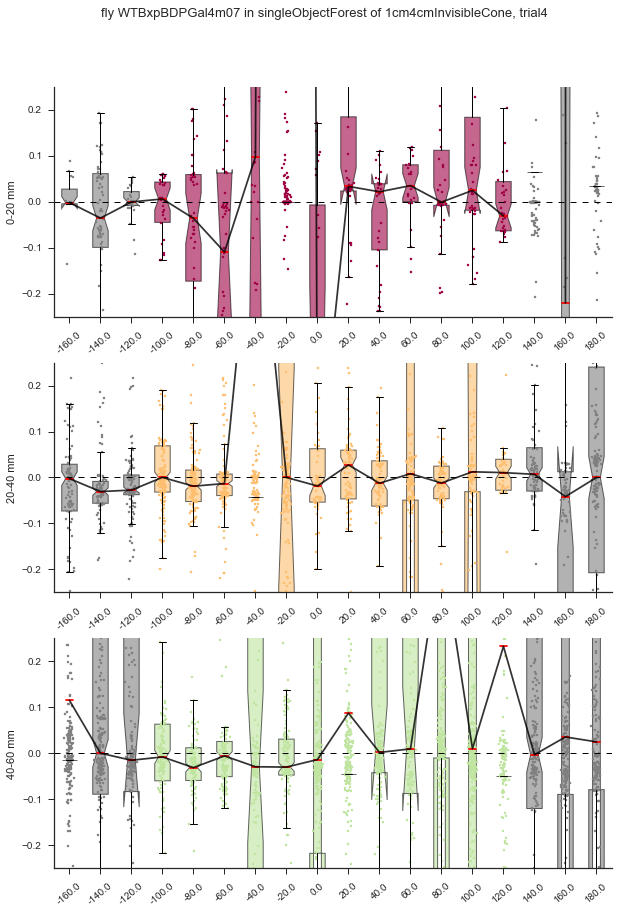

In [814]:
# Bin values and generate box plot
nGammaBins = 18
nDistBins = 3
gammaBins = np.linspace(-np.pi, np.pi, nGammaBins+1)
gammaBins = gammaBins[1:]

distBins = np.linspace(0, round(max(objDist[~np.isnan(objDist)])), nDistBins+1)
distBins = distBins[1:]

curvDigitized = []
gammaFullDigitized = []

cmap = plt.cm.get_cmap('Spectral')
colors = np.zeros((nDistBins,4))
outcolor = [0.5,  0.5,  0.5,  1]

binInd = np.digitize(objDist,distBins)

for i in range(nDistBins):
    curvDigitized.append(curv[binInd==i])
    gammaFullDigitized.append(gammaFull[binInd==i])
    colors[i] = cmap(float(i)/nDistBins)

curvBoxPlot=plt.figure(figsize=(10,14))
curvBoxPlot.suptitle(titleString, fontsize=13)
for distLevel in range(nDistBins):
    curvDoubleDigitized = []
    curvDigitizedMedian = np.zeros(nGammaBins)
    binInd = np.digitize(gammaFullDigitized[distLevel],gammaBins)
    
    for i in range(nGammaBins):
        curvDoubleDigitized.append(curvDigitized[distLevel][binInd==i])
        curvDigitizedMedian[i] = np.median(curvDigitized[distLevel][binInd==i])
    
    outcolorList = np.reshape(np.repeat(outcolor,(180-120)/(360/nGammaBins)),(4,(180-120)/(360/nGammaBins))).transpose()
    incolorList = np.reshape(np.repeat(colors[distLevel],(2*120)/(360/nGammaBins)),(4,(2*120)/(360/nGammaBins))).transpose()
    colorList = np.vstack((outcolorList, incolorList, outcolorList))
    
    ax = curvBoxPlot.add_subplot(nDistBins,1,distLevel+1)
    for g in range(nGammaBins):
        y = curvDoubleDigitized[g]
        # Add some random "jitter" to the x-axis
        x = np.random.normal(g+1, 0.06, size=len(y))
        plt.plot(x, y, '.', color = colorList[g], alpha=1,markersize=5)
    
    box = ax.boxplot(curvDoubleDigitized,notch=True,patch_artist=True)
    plt.setp(box['boxes'],alpha = 0.6, edgecolor='black')
    plt.setp(box['whiskers'], color='black', linewidth=1, linestyle='-')
    plt.setp(box['caps'], color='black', linewidth=1, linestyle='-')
    for patch, color in zip(box['boxes'], colorList):
        patch.set_facecolor(color)
    ax.set_ylabel(str(int(distBins[distLevel]-np.mean(np.diff(distBins)))) + '-' + str(int(distBins[distLevel])) + ' mm')
    plt.xticks(range(1,len(gammaBins)+1),np.round(gammaBins*180/np.pi,2), rotation=40)    
    ax.plot(range(1,len(gammaBins)+1),curvDigitizedMedian,color='black',alpha=0.8)
    ax.set_ylim(-0.25,0.25)
    ax.axhline(0,color='k',linewidth=1, linestyle='--')

    myAxisTheme(ax)

In [815]:
from plottingUtilities import makeNestedPlotDirectory
analysisDir = dataDir + 'analysis/'

makeNestedPlotDirectory(analysisDir, 'headingVsCurvature/', objecttype + sep)

curvBoxPlot.savefig(analysisDir + 'headingVsCurvature/' + objecttype + sep
                   + FODataFile[0:-4] + '_headingVsCurvatureBoxPlot_trial' + str(trial) + '.pdf', format='pdf')


Analysis directory already exists.
Plot directory already exists.


### Save position and velocities for future analysis

In [553]:
toSave = {'time': time_ds,
               'xPos': xPos_ds,
               'yPos': yPos_ds,
               'xPosInMiniarena': xPosMA_ds,
               'yPosInMiniarena': yPosMA_ds,
               'headingAngle': angle_ds,
               'rotVelo': vRot_ds,
               'transVelo': vTrans_ds,
               'objectDistance': objDist,
               'gamma': gamma}
# Alternatively use numpy array:
# toSave = np.zeros((10, len(time_ds)))
# toSave[:,:] = np.vstack((time_ds,xPos_ds, yPos_ds, xPosMA_ds, yPosMA_ds, angle_ds, vRot_ds,vTrans_ds,objDist,gamma))
#save data in this format as *.npy for easy loading..
np.save(expDir + FODataFile[:-4], toSave)

### Comparison of flyVR vs. treadmill trajectory

In [231]:
dx1 = FOData[1:,6]
dy1 = FOData[1:,7]
dx2 = FOData[1:,8]
dy2 = FOData[1:,9]

In [232]:
# parameter definitions
gammaRad = 45*np.pi/180; #absolute angle of cameras to longitudinal axis (of fly)
conversionFactor_pitch = -1.76
conversionFactor_yaw = - 1.69
rBall = float(ballRadius_mm)
pixel2mm = 0.013514

# compute virtual rotation of fly
vFwdBall = - (dy1 + dy2) * np.cos(gammaRad); #add components along longitudinal axis
vSideBall = - (dy1 - dy2) * np.sin(gammaRad); #add components along transversal axis
vRotBall = - (dx1 + dx2)/2 #average measured displacement along aximuth

# convert A.U. --> pixel --> mm
vFwdBall = pixel2mm * vFwdBall * conversionFactor_pitch # use scaling factor for pitch
vSideBall = pixel2mm * vSideBall * ((conversionFactor_yaw + conversionFactor_pitch)/2) #use mean
vRotBall = pixel2mm * vRotBall * conversionFactor_yaw # use scaling factor for yaw

# convert to mm/s
vFwdBall = vFwdBall / np.diff(time)
vSideBall = vSideBall / np.diff(time)
vRotBall =  vRotBall / np.diff(time)

vRot_TM = - vRotBall / rBall #mm/s to deg/s

# Assume initial position (0 0 0) = (x-coord, y-coord, theta): 
# --> fly in origin, aligned with x axis (head forward)
# During measurement coordinate system is fly-centered, moves with fly.
# Compute all changes along those axes by updating theta and
# projecting the position changes onto the fixed coordinate system

theta = np.cumsum(vRot_TM * np.diff(time))
theta = np.mod((theta + np.pi),2*np.pi) - np.pi

# movement in x and y direction
yTM_i = vSideBall * np.cos(-theta) - vFwdBall * np.sin(-theta) #compute increments x_i
yTM = np.cumsum(yTM_i* np.diff(time)) # integrate x_i to get path

xTM_i = vSideBall * np.sin(-theta) + vFwdBall * np.cos(-theta)
xTM = np.cumsum(xTM_i * np.diff(time))

vTrans_TM = np.hypot(xTM_i, yTM_i)


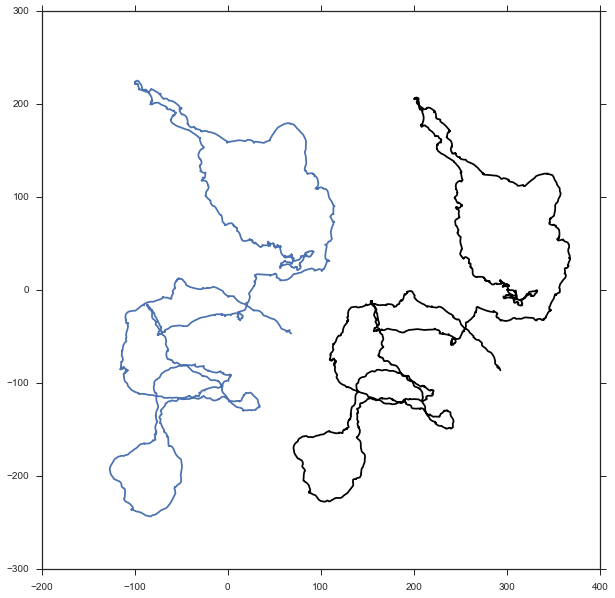

In [233]:
VRTMplot = plt.figure(figsize = (20,10))
ax = VRTMplot.add_subplot(111)
plt.plot(300 + xTM, yTM,'k')
plt.plot(xPos_ds,yPos_ds)
ax.set_aspect('equal')

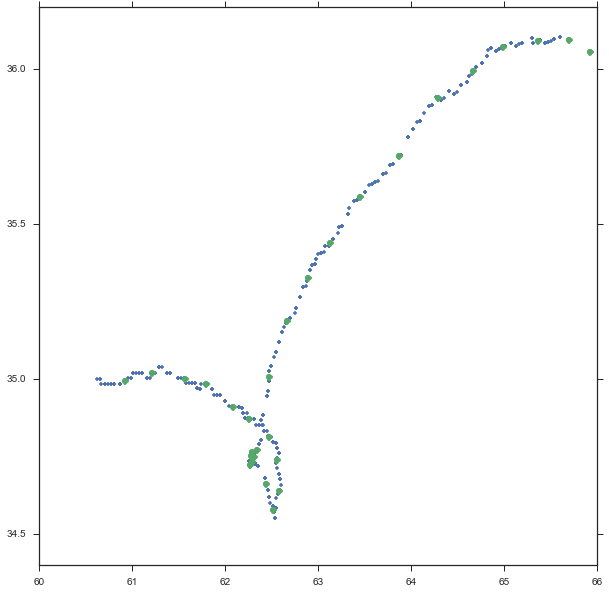

In [257]:
plt.figure(figsize = (10,10))
plt.plot(FOData[1:500,1],FOData[1:500,2],'.')
plt.plot(xPos_ds[1:30],yPos_ds[1:30],'o')

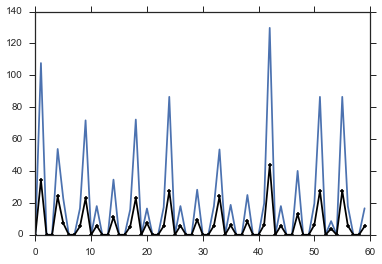

In [235]:
plt.plot(vTrans[0:60]*np.pi)
plt.plot(vTrans_TM[0:60],'k.-')

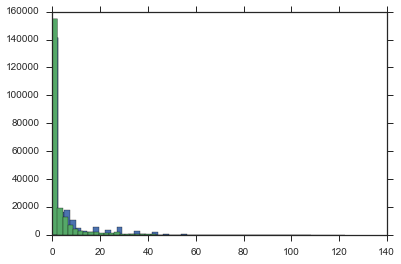

In [242]:
plt.hist(vTrans_TM,bins = 50);
plt.hist(vTrans,bins = 50);

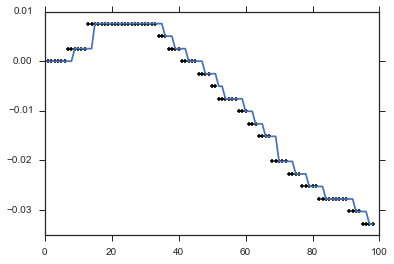

In [236]:
plt.plot(theta[1:100],'k.')
plt.plot(angle[1:100])

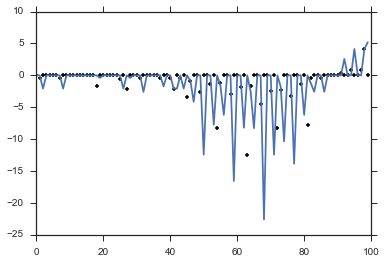

In [238]:
plt.plot(vRot_TM[100:200],'k.')
plt.plot(vRot[100:200])

### Debugging

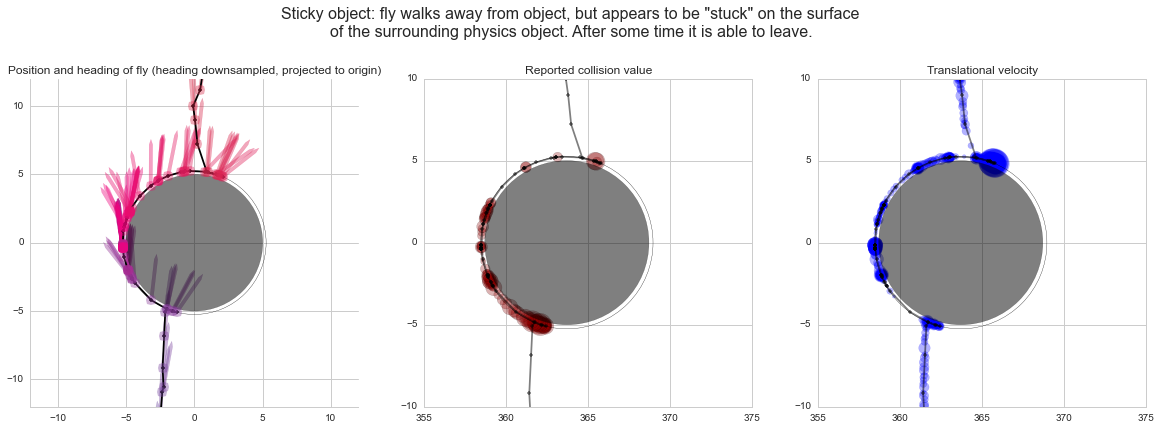

In [201]:
fig = plt.figure(figsize=(20,7))

fig.suptitle('Sticky object: fly walks away from object, but appears to be "stuck" on the surface'+
             '\nof the surrounding physics object. After some time it is able to leave.', fontsize = 16)

frameRange = range(300*20,400*20,5)
sns.set_style("whitegrid")
ax = fig.add_subplot(131)
plt.plot(xPosMA_ds[frameRange],yPosMA_ds[frameRange],'k.-')
plotPosInRange(ax,axTime,frameRange,time_ds,xPosMA_ds,yPosMA_ds,angle_ds,colMap,3,0.4,20)
circle1=plt.Circle((0,0),5,color='k',alpha=0.5)
circle2=plt.Circle((0,0),5.25,color='k',fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)
plt.xlim((-12,12))
plt.ylim((-12,12))
ax.set_aspect('equal')
ax.set_title('Position and heading of fly (heading downsampled, projected to origin)')

frameRange = range(320*360,370*360,5)
ax = fig.add_subplot(132)
plt.plot(xPos_ds[range(320*20,370*20,5)],yPos_ds[range(320*20,370*20,5)],'.-', alpha = 0.5, color = 'black',markersize = 7)
plt.scatter(FOData[frameRange,1],FOData[frameRange,2],s=5000*FOData[frameRange,10], c = 'darkred', alpha = 0.3)
plt.ylim((-10,10))
plt.xlim((355,375))
circle1=plt.Circle((363.7,0),5,color='k',alpha=0.5)
circle2=plt.Circle((363.7,0),5.25,color='k',fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.set_aspect('equal')
ax.set_title('Reported collision value')

ax = fig.add_subplot(133)
plt.plot(xPos_ds[range(320*20,370*20,5)],yPos_ds[range(320*20,370*20,5)],'.-', alpha = 0.5, color = 'black',markersize = 7)
plt.scatter(FOData[frameRange,1],FOData[frameRange,2],s=5*vTrans, color = 'blue', alpha = 0.3)
plt.ylim((-10,10))
plt.xlim((355,375))
circle1=plt.Circle((363.7,0),5,color='k',alpha=0.5)
circle2=plt.Circle((363.7,0),5.25,color='k',fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.set_aspect('equal')
ax.set_title('Translational velocity')

### Align trajectories along turns

138


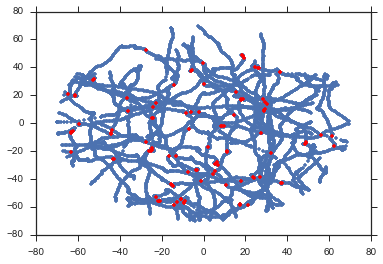

In [253]:
# find sharp turn starts
minTurnDist = 15

turnLoc = np.where(turnMask.astype('int')>0)[0]
turnStart = turnLoc[np.where(np.diff(turnLoc)>minTurnDist)[0]-N]

plt.plot(xPosMA_ds,yPosMA_ds,'.')
plt.plot(xPosMA_ds[turnStart],yPosMA_ds[turnStart],'r.')

print(len(turnStart))

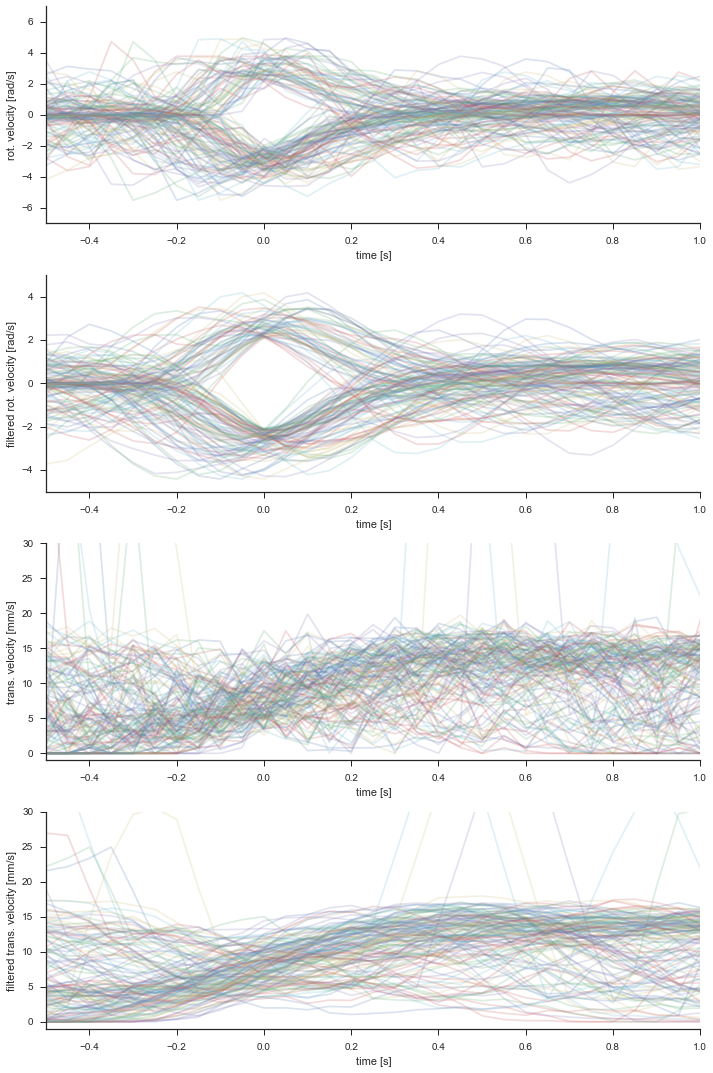

In [254]:
fig = plt.figure(figsize = (10,15))
vrot = fig.add_subplot(411)
vrotfilt = fig.add_subplot(412)
vtrans = fig.add_subplot(413)
vtransfilt = fig.add_subplot(414)

sampleRt = np.median(np.diff(time_ds))
preturn = 10
postturn = 20
timeRange = np.linspace(-preturn*sampleRt,(postturn)*sampleRt,(preturn + postturn+1))
for turn in turnStart:
    printRange = range(turn-preturn,turn+postturn+1)
    vrot.plot(timeRange,vRot_ds[printRange],alpha = 0.2)
    vrotfilt.plot(timeRange,vRotFilt_ds[printRange],alpha = 0.2)
    vtrans.plot(timeRange,vTrans_ds[printRange],alpha = 0.2)
    vtransfilt.plot(timeRange,vTransFilt_ds[printRange],alpha = 0.2)

vrot.set_ylabel('rot. velocity [rad/s]')
vrot.set_ylim((-7,7))
vrot.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vrot.set_xlabel('time [s]')
myAxisTheme(vrot)

vrotfilt.set_ylabel('filtered rot. velocity [rad/s]')
vrotfilt.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vrotfilt.set_ylim((-5,5))
vrotfilt.set_xlabel('time [s]')
myAxisTheme(vrotfilt)

vtrans.set_ylabel('trans. velocity [mm/s]')
vtrans.set_ylim((-1,30))
vtrans.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vtrans.set_xlabel('time [s]')
myAxisTheme(vtrans)

vtransfilt.set_ylabel('filtered trans. velocity [mm/s]')
vtransfilt.set_ylim((-1,30))
vtransfilt.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vtransfilt.set_xlabel('time [s]')
myAxisTheme(vtransfilt)

plt.tight_layout()

### Scraps

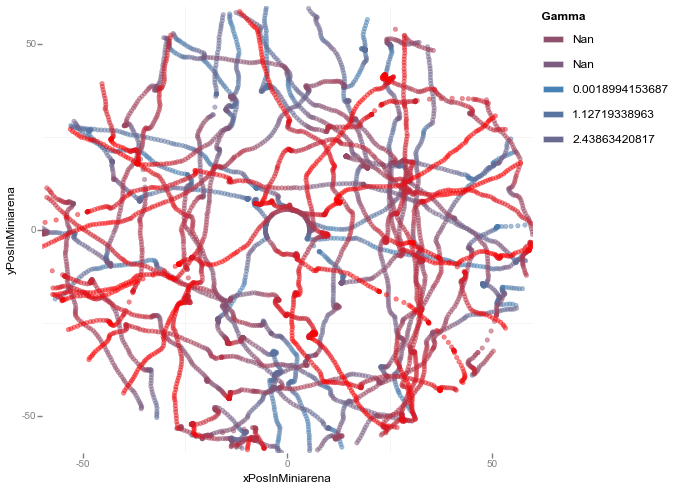

<ggplot: (504899201)>

In [147]:
import pandas as pd
FOdf = pd.DataFrame.from_dict(FOData[()],orient='columns')
FOdf['moving'] = (FOdf['transVelo']>2).astype('string')

from ggplot import *
ggplt = ggplot(aes(x='xPosInMiniarena',y='yPosInMiniarena', color='gamma'), data=FOdf) + geom_point(alpha=0.5)
ggplt = ggplt + xlim(-60,60) + ylim(-60,60) + scale_color_gradient(low='steelblue', high='red') + theme_bw()
ggplt

In [285]:
# Collapse trajectoies in a periodic (hexgonally) tiled world onto central hexagon
# Input: x and y coordinates

xPosHex = np.zeros(len(FOData[:,1]))
yPosHex = np.zeros(len(FOData[:,1]))

xPosHex[:] = np.asarray(FOData[:,1])
yPosHex[:] = np.asarray(FOData[:,2])

# Move each point onto corresponding location in central hexagon (clipping regions close to wall)
h = hTrgle #height of triangle
s = aTrgle #side of triangle
i = h #inter-island distance
slope = 2*h/s

for pt in range(len(xPosHex)):
    # 1) Check in which trianlge point is (first quadrant, then triangle)
    # 2) Check if point is in central hexagon, translate if not
    # 3) Cut off any trajectories outside of central hexagon after translation
    x = xPosHex[pt]
    y = yPosHex[pt]
    
    if(y >= 0):
        if(x > 0): #  --> quadrant 1
            if(y/x >= slope): #  --> trianle 1
                if(y > i): # hex 1: shift by (0,i)
                    xPosHex[pt] = x
                    yPosHex[pt] = y-i
                #plot(xPosHex[pt],yPosHex[pt],'.','color', colourCode(1,:))
            else: # y/x < slope  --> trianle 6
                if(y > (-slope*x + 2*i)): # hex 6: shift by (3s,i/2)
                    xPosHex[pt] = x-s/2
                    yPosHex[pt] = y-i/2
                #plot(xPosHex[pt],yPosHex[pt],'.','color', colourCode(6,:))

        else: #x <= 0 --> quadrant 2
            if(y/x < -slope): # --> trianle 1
                if(y > i): # hex 1: shift by (0,i)
                    xPosHex[pt] = x
                    yPosHex[pt] = y-i
                #plot(xPosHex[pt],yPosHex[pt],'.','color', colourCode(1,:))
            else: # y/x <= -slope  --> trianle 2
                if(y > (slope*x + 2*i)): # hex 2: shift by (-3s,i/s)
                    xPosHex[pt] = x+s/2
                    yPosHex[pt] = y-i
                #plot(xPosHex[pt], yPosHex[pt],'.','color',colourCode(2,:))

    else: # y < 0
        if(x > 0): # --> quadrant 4
            if(y/x < -slope): # --> trianle 4
                if(abs(y) > i): # hex 4
                    xPosHex[pt] = x
                    yPosHex[pt] = y+i # shift by (0,i)
                #plot(xPosHex[pt],y_hex(pt),'.','color', colourCode(4,:))
            else: # y/x >= -slope  --> trianle 5
                if(y < (slope*x - 2*i)): # hex 5
                    xPosHex[pt] = x-s/2
                    yPosHex[pt] = y+i; # shift by (3s,-i/s)
                #plt.plot(xPosHex[pt],yPosHex[pt],'.','color',colourCode(5,:))

        else: # x <= 0 --> quadrant 3
            if(y/x >= slope): # --> trianle 4
                if(abs(y) > i): # hex 4: shift by (0,i)
                    xPosHex[pt] = x
                    yPosHex[pt] = y+i
                #plt.plot(xPosHex[pt], yPosHex[pt], '.', 'color', colourCode(4,:))
            else:# y/x < slope  --> trianle 3
                if(y < (-slope*x - 2*i)): # hex 3: shift by (-3*s,-i/s)
                    xPosHex[pt] = x+s/2
                    yPosHex[pt] = y+i/2 
                #plt.plot(xPosHex[pt], yPosHex[pt], '.', 'color', colourCode(3,:))
    
#    if(abs(yPosHex[pt]) > h):
#        yPosHex[pt] = np.nan
#        xPosHex[pt] = np.nan
#    if(abs(yPosHex[pt]) > -h/s*abs(xPosHex[pt]) + 2*h):
#        yPosHex[pt] = np.nan
#        xPosHex[pt] = np.nan


In [163]:
#collapse2triangleUnit <- function(x,y,heading,ids,a,h,numR,numC){
# Collapse trajectory (x,y) to triangular unit (side length a, hight h)
# Triangles are assumed to be arranged in hexagon with numR #rows and numC #columns per quadrant
  
# This simple algorithm doesn't conserve global orientation w.r.t virtual world coordinates.
# Instead the virtual trajecotry is folded onto iself repeatedly.

h = hTrgle #height of triangle
a = aTrgle #side of triangle

# (1) collapse onto first quadrant
xPosTrg = np.zeros(len(FOData[:,1]))
yPosTrg = np.zeros(len(FOData[:,1]))
angleTrg = np.zeros(len(FOData[:,1]))

xPosTrg[:] = abs(np.asarray(FOData[:,1]))
yPosTrg[:] = abs(np.asarray(FOData[:,2]))
angleTrg[:] = angle
  
# (2) collapse y onto one row of triangles
yPosTrg[yPosTrg > h] = 2*h - yPosTrg[yPosTrg > h] 
  
# prune away what was outside of the original hexagon
#angleTrg = angleTrg[yPosTrg >= 0]
#ids <- ids[y >= 0]
#xPosTrg = xPosTrg[yPosTrg >= 0]
#yPosTrg = yPosTrg[yPosTrg >= 0]
    
# (3) collapse x onto one column of trianles
#       --> now everything is contained in a a-times-h rectangle
xPosTrg[xPosTrg > a] = xPosTrg[xPosTrg > a] - a
  
# prune away what was outside of the original hexagon
angleTrg = angleTrg[xPosTrg <= a]
#ids = ids[x <= a]
yPosTrg = yPosTrg[xPosTrg <= a]
xPosTrg = xPosTrg[xPosTrg <= a]
  
# (4) collapse onto single triangle
leftT = yPosTrg > 2*(h/a) * xPosTrg
rightT = yPosTrg > 2*h*(1- (xPosTrg/a))
  
xPosTrg[leftT] = xPosTrg[leftT] + a/2
yPosTrg[leftT] = abs(yPosTrg[leftT] - h)
  
xPosTrg[rightT] = xPosTrg[rightT] - a/2
yPosTrg[rightT] = abs(yPosTrg[rightT] - h)
